In [36]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from os import listdir
from sklearn.linear_model import LinearRegression
from scipy.signal import find_peaks
from statsmodels.tsa.stattools import acf

def structure_function_est(array,noise,times):
    '''
    Uses the SFtrue function as defined in https://arxiv.org/pdf/1604.05858.pdf equation 12
    '''
    y = []
    for t in times:
        p = 0
        for n in range(len(array)-t):
            point = (array[n] - array[n+t])**2 - (noise[n]**2)*array[n] - (noise[n]**2)*array[n+t]
            print(point)
            p = p + point
        y.append(np.sqrt(p / len(array-t)))
    return y

def structure_function_tru(array,noise):
    '''
    Uses the SFtrue function as defined in https://arxiv.org/pdf/1604.05858.pdf equation 8 line 1
    '''
    y = acf(array,fft=True,nlags=len(array))
    noise = np.var(array)
    for n in range(len(y)):
        y[n] = np.sqrt(2 * (noise**2)*(1 - y[n]))
    return y

def get_params(sf,timescale):
    decorr = np.where(timescale==min(timescale, key=lambda x:abs(x-1)))[0][0]
    
    regressor = LinearRegression()  
    regressor.fit(np.log(timescale[1:decorr]).reshape(-1,1),np.log(sf[1:decorr]).reshape(-1,1))
    gamma = regressor.coef_
    a = np.e**regressor.intercept_
    return a, gamma, decorr
    
def cool_plot(curve='C:/Users/811261/Documents/Research/Lightcurves/sector_lightcurves/0-0lc.pickle',name='Thing'):
    with open(curve,'rb') as rfile:
        lc = pickle.load(rfile)
    lc.quality = np.zeros(len(lc.flux),dtype='int')
    lc = lc.remove_nans().remove_outliers(sigma=5)
    
    fig,axs = plt.subplots(2,figsize=(10,5))
    fig.suptitle("Collected Data for TIC {0}".format(lc.targetid))
    fig.subplots_adjust(hspace=0.5)
    axs[0].set_xlabel("Time (BTJD Days)")
    axs[0].set_ylabel("Flux (e/s)")
    axs[0].set_title("Light Curve")
    axs[0].plot(lc.time,lc.flux,color='blue',linewidth=0.5)
    
    y = structure_function_tru(lc.flux,lc.flux_err)
    a, gamma, decorr = get_params(y,lc.time-lc.time[0])
    print("SF(t) = {0} * t ^ {1}".format(a[0],gamma[0][0]))
    axs[1].set_yscale('log')
    axs[1].set_xscale('log')

    axs[1].set_xlabel("Time Displacement (BTJD)")
    axs[1].set_ylabel("SF (mag)")
    axs[1].set_title("Structure Function")
    axs[1].plot(lc.time-lc.time[0],y,color='b')
    axs[1].axvline(x=(lc.time-lc.time[0])[decorr],color='g',linestyle='dashed')
    axs[1].plot((lc.time-lc.time[0])[:decorr],a*((lc.time-lc.time[0])[:decorr])**gamma[0],color='r',linestyle='dashed')
    plt.show()
    #plt.savefig('Sf{0}.png'.format(name))
    #plt.close()

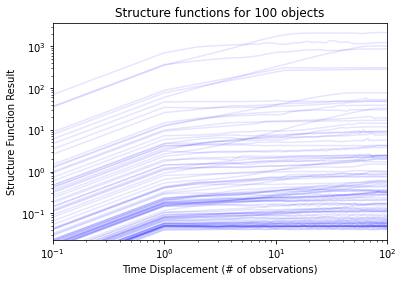

In [37]:
fig = plt.figure()
ax = plt.subplot()
for n in listdir('E:/sector_lightcurves/')[0:100]:   
    try:
        with open('E:/sector_lightcurves/' + str(n),'rb') as rfile:
            lc = pickle.load(rfile)
        lc.quality = np.zeros(len(lc.flux),dtype='int')
        lc = lc.remove_nans().remove_outliers(sigma=20)
    except:
        continue
    times = range(len(lc.time))
    y = structure_function_tru(lc.flux,lc.flux_err)
    ax.plot(times,y,color='blue',alpha=0.1)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(0.1,100)
plt.xlabel("Time Displacement (# of observations)")
plt.ylabel("Structure Function Result")
plt.title("Structure functions for 100 objects")
plt.savefig('fig2.png',dpi=1000)

C:\Users\abcmo\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


(-0.1, 200)

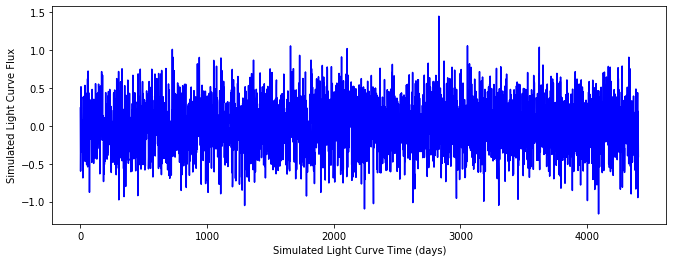

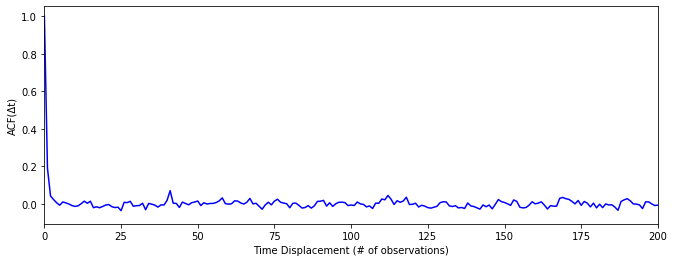

In [69]:
length = 4406
strength = -0.8

array = []
value = 0
for n in range(length):
    value = value + np.random.normal(loc=value*strength, scale=0.32, size=1)
    array.append(value)
    
y = acf(array,nlags=len(array))

fig = plt.figure(figsize=(11,4))
ax = plt.subplot()
plt.xlabel("Simulated Light Curve Time (days)")
plt.ylabel('Simulated Light Curve Flux')
ax.plot(array,color='blue')

fig = plt.figure(figsize=(11,4))
ax = plt.subplot()
ax.set_yscale('linear')
ax.set_xscale('linear')
ax.set_xlim(0,length)
plt.xlabel("Time Displacement (# of observations)")
plt.ylabel("ACF(\u0394t)")
ax.plot(range(length),y,color='blue')
ax.set_xlim(-0.1,200)

In [42]:
glist = []
mlist=[]
alist=[]
real_a=[]
real_gamma=[]
masslist = pd.read_csv('E:/catalogues/final_quasar_catalogue.csv', sep=',', usecols=['Lbol'],header=0,squeeze=True)
real_a_list = pd.read_csv('E:/catalogues/final_quasar_catalogue.csv', sep=',', usecols=['VAR_A'],header=0,squeeze=True)
real_gamma_list = pd.read_csv('E:/catalogues/final_quasar_catalogue.csv', sep=',', usecols=['VAR_GAMMA'],header=0,squeeze=True)

for curve in listdir('E:/lightcurves')[:10000]:
    try:
        row = int(curve.split('lc')[0])
        if np.isnan(masslist[row]) == True:
            continue
        with open('E:/lightcurves/' + str(curve),'rb') as rfile:
            lc = pickle.load(rfile)
        lc.quality = np.zeros(len(lc.flux),dtype='int')
        lc = lc.remove_nans().remove_outliers(sigma=5)
        y = structure_function_tru(lc.flux,lc.flux_err)
        a, gamma, decorr = get_params(y,lc.time-lc.time[0])
        alist.append(a[0])
        glist.append(gamma[0][0])
        mlist.append(masslist[row])
        real_a.append(real_a_list[row])
        real_gamma.append(real_gamma_list[row])
    except:
        print("oof")

oof


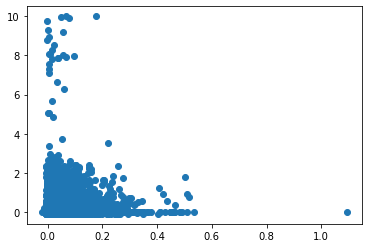

In [39]:
plt.scatter(glist,real_gamma)

ValueError: x and y must be the same size

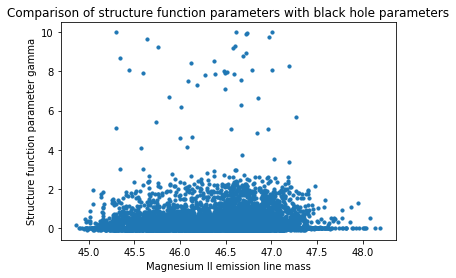

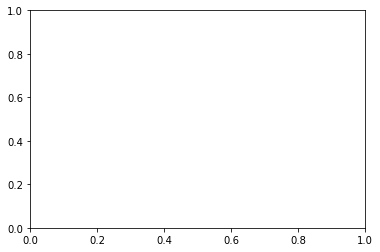

In [45]:
mlist = np.array(mlist)
plt.scatter(mlist,real_gamma,s=10,cmap='plasma')
plt.title('Comparison of structure function parameters with black hole parameters')
plt.xlabel('Magnesium II emission line mass')
plt.ylabel('Structure function parameter gamma')
#plt.xlim(0.001,3e45)
#plt.colorbar()

fig = plt.figure()
plt.scatter(mlist,real_a_list,s=10,cmap='plasma')
plt.title('Comparison of structure function parameters with black hole parameters')
plt.xlabel('Magnesium II emission line mass')
plt.ylabel('Structure function parameter alpha')
#plt.ylim(0.001,5000)
#plt.colorbar()

In [15]:
np.mean(mlist)

1.6250272456853985e+43

In [4]:
pd.read_csv('C:/Users/abcmo/Documents/Research/Quasar Catalogue/final_quasar_catalogue.csv', sep=',',header=0)

,SDSS_NAME,RA,DEC,THING_ID,PLATE,MJD,FIBERID,Z_VI,Z_PIPE,ERR_ZPIPE,...,L3000,eL3000,L1350,eL1350,MBH_MgII,MBH_CIV,Lbol,eLbol,nEdd,SECTORS
0,000033.16+323530.5,0.138173,32.591821,387828308,6498,56565,864,2.202000,2.214343,0.000214,...,45.740,0.133,45.945,0.090,9.406,NaN,46.503,0.075,-1.003,1
1,000113.15+322331.8,0.304819,32.392187,385977804,6498,56565,912,2.130408,2.130408,0.000256,...,45.928,0.101,46.076,0.104,9.510,9.176,46.648,0.072,-0.962,1
2,000131.88+325252.6,0.382840,32.881298,389439070,7144,56564,203,0.854919,0.854919,0.000148,...,45.271,0.075,NaN,NaN,8.568,NaN,45.993,0.067,-0.675,1
3,000201.32+315535.3,0.505540,31.926491,383493578,6498,56565,886,2.295000,2.274535,0.000191,...,NaN,NaN,45.984,0.088,NaN,9.227,46.565,0.088,-0.762,1
4,000203.11+315153.1,0.512965,31.864774,383493592,7144,56564,130,2.264526,2.264526,0.000550,...,NaN,NaN,46.150,0.090,NaN,9.662,46.731,0.090,-1.031,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21131,235752.83+341601.7,359.470141,34.267147,399006152,7144,56564,664,0.610347,0.610347,0.000072,...,45.098,0.091,NaN,NaN,8.465,NaN,45.820,0.062,-0.745,1
21132,235832.06+330511.3,359.633584,33.086491,391500440,7144,56564,336,0.758802,0.758802,0.000052,...,45.053,0.087,NaN,NaN,8.781,NaN,45.765,0.067,-1.116,1
21133,235852.38-105822.1,359.718274,-10.972831,21087916,7167,56604,367,1.984000,1.961312,0.000292,...,46.357,0.092,46.528,0.092,9.391,NaN,47.089,0.065,-0.402,1
21134,235903.25+325339.8,359.763552,32.894408,389612903,6498,56565,825,2.676150,2.676150,0.000371,...,NaN,NaN,46.143,0.084,NaN,9.134,46.724,0.084,-0.510,1


array([[-1.02847054]])

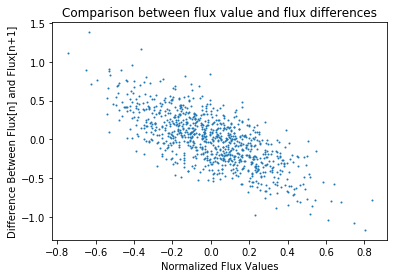

In [31]:
curve = '9lc.pickle'
with open('F:/quasar_database/lightcurves/' + str(curve),'rb') as rfile:
    lc = pickle.load(rfile)
lc.quality = np.zeros(len(lc.flux),dtype='int')
lc = lc.remove_nans().remove_outliers(sigma=5)
flux = lc.flux

flux_diffs = [flux[n+1]-flux[n] for n in range(len(flux)-1)]
plt.scatter(flux[:len(flux)-1],flux_diffs,s=1)
plt.xlabel("Normalized Flux Values")
plt.ylabel("Difference Between Flux[n] and Flux[n+1]")
plt.title("Comparison between flux value and flux difference")
#plt.xlim(-1.5,1.5)
#plt.ylim(-1.5,1.5)

#np.std(flux_diffs)

X = flux[:len(flux)-1].reshape(-1, 1)  # values converts it into a numpy array
Y = np.array(flux_diffs).reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
linear_regressor.coef_

-0.0005886572574048004
-3.6950997702586825
3.851409678977549
0.3008602002443177


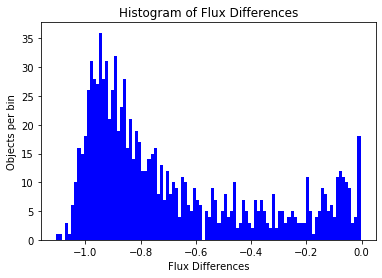

In [61]:
plt.hist(l, color = 'blue',bins = 100)

# Add labels
plt.title('Histogram of Flux Differences')
plt.xlabel('Flux Differences')
plt.ylabel('Objects per bin')
#plt.savefig('sect.png',dpi=1000)
print(np.mean(flux_diffs))
print(np.min(flux_diffs))
print(np.max(flux_diffs))
print(np.std(flux))

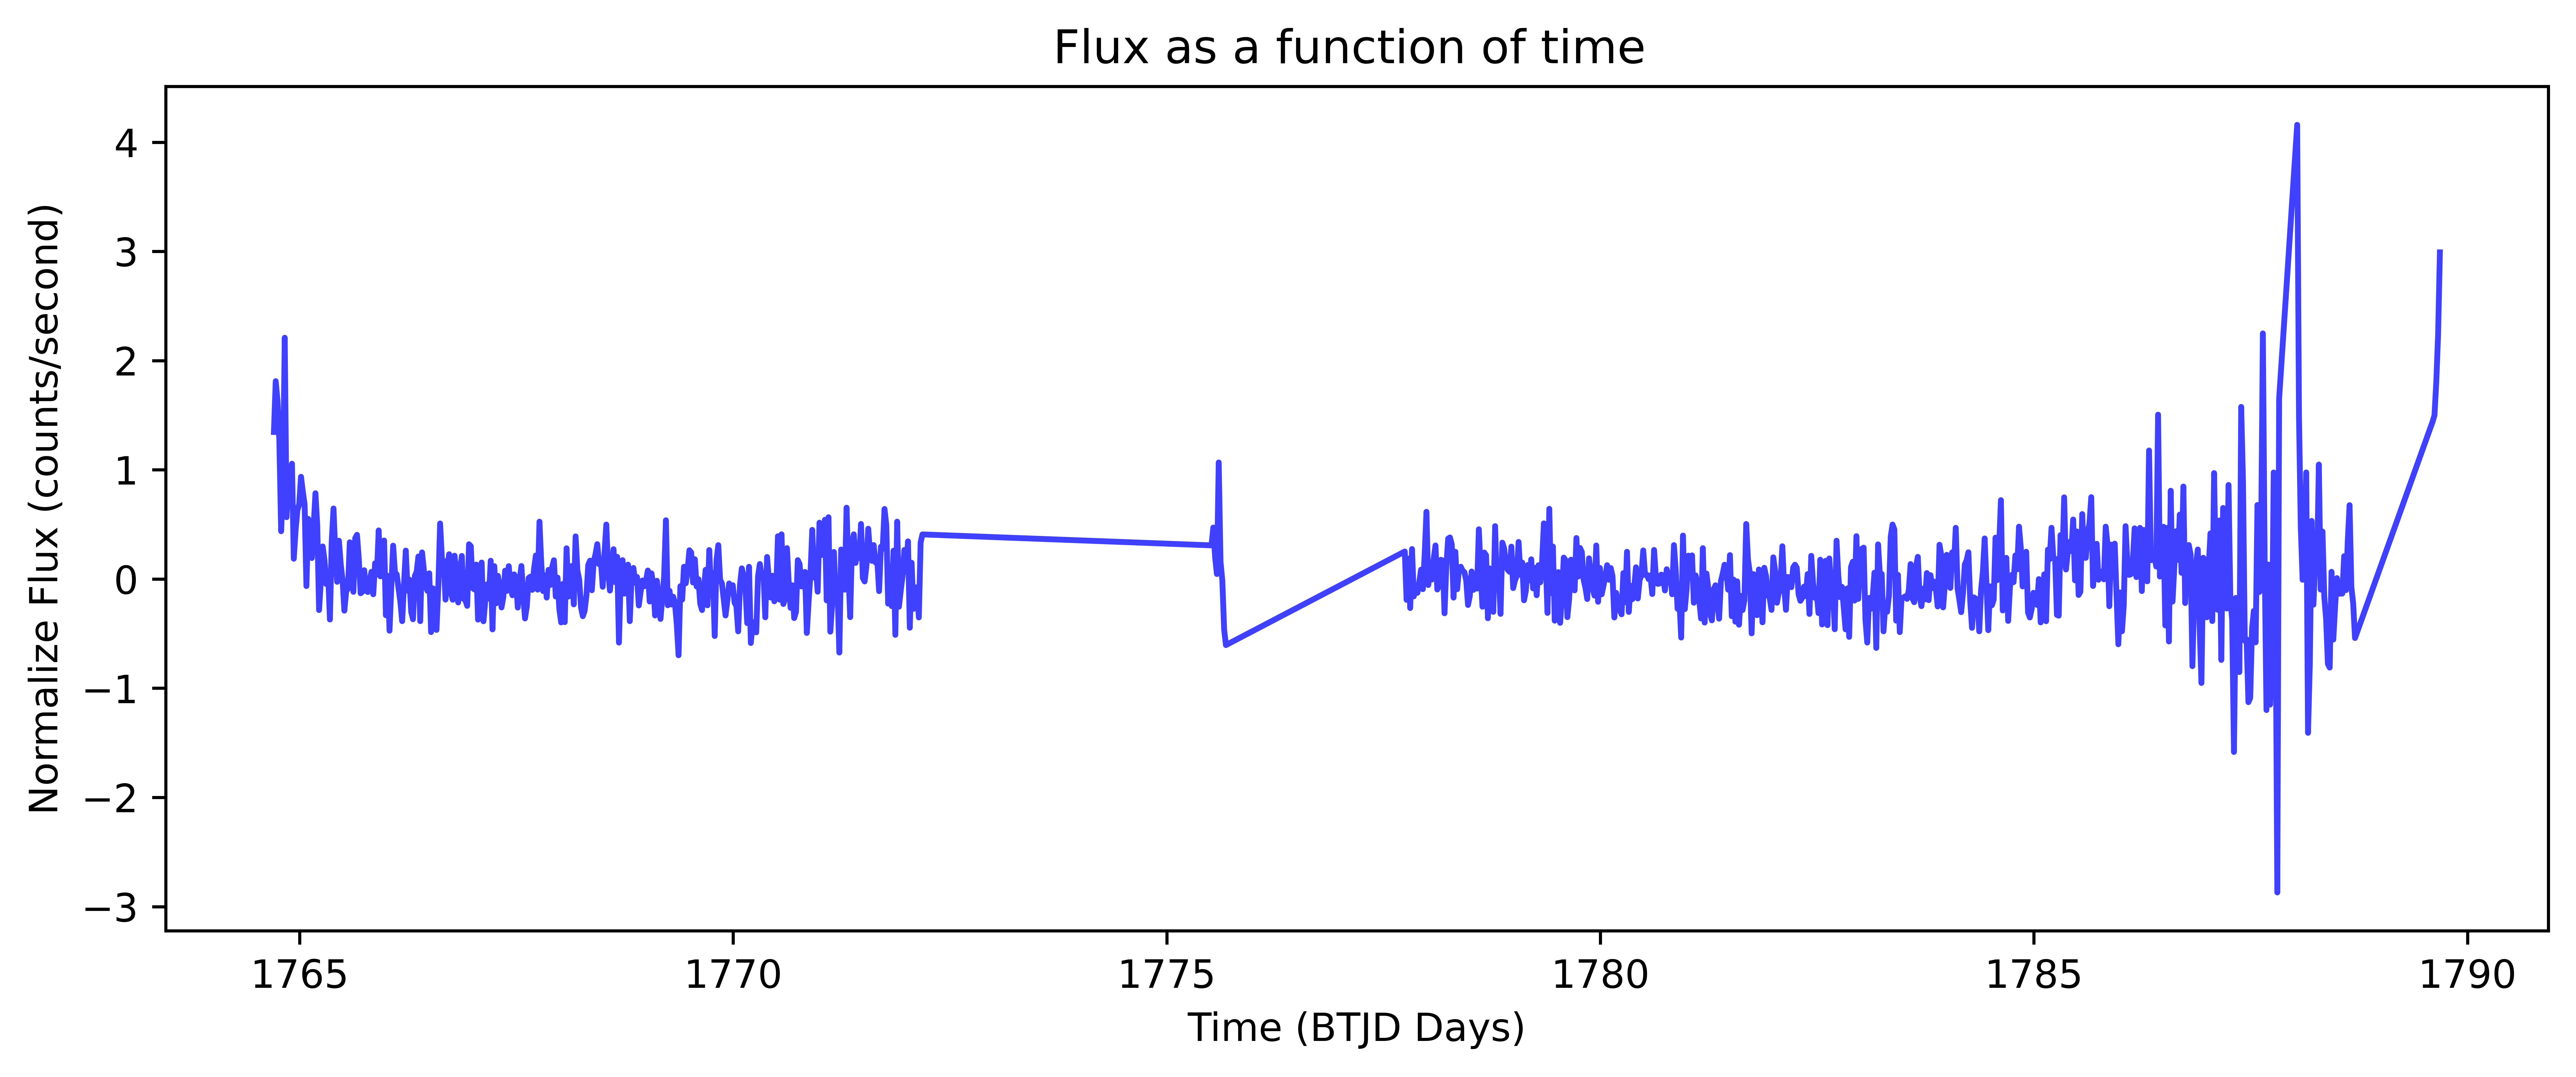

In [51]:
import lightkurve as lk
import pickle
import matplotlib.pyplot as plt
import numpy as np

def load(file='1lc.pickle',width=18,height=3,dpi=1000,alpha=0.75,bin=True,bins=2000,sigma=20,save=False):
    plt.figure(figsize=(width, height), dpi=dpi)
    with open(file,'rb') as rfile:
        lc = pickle.load(rfile)
    lc.quality = np.zeros(len(lc.flux),dtype='int')
    if bin == True:
        lc = lc.remove_nans().remove_outliers(sigma=sigma).bin(bins=bins)
    elif bin == False:
        lc = lc.remove_nans().remove_outliers(sigma=sigma)
    plt.plot(lc.time,lc.flux,color='blue',alpha=alpha,label='TIC ' + str(lc.targetid))
    #plt.xlim(left=1340,right=1380)
    plt.xlabel("Time (BTJD Days)")
    plt.ylabel("Normalize Flux (counts/second)")
    plt.title("Flux as a function of time ")#" + 'TIC ' + str(lc.targetid))
    if save == True:
        plt.savefig(str(file) + ".png")

   
def load2(file='1lc.pickle',file2='2lc.pickle',width=18,height=3,dpi=1000,alpha=0.75,bin=True,save=False):
    plt.figure(figsize=(width, height), dpi=dpi)
    with open(file,'rb') as rfile:
        lc = pickle.load(rfile)
    if bin == True:
        lc = lc.remove_nans().remove_outliers().bin()
    elif bin == False:
        lc = lc.remove_nans().remove_outliers()
    plt.plot(lc.time,lc.flux,color='red',alpha=alpha,label='TIC ' + str(lc.targetid))
    
    with open(file2,'rb') as rfile:
        lc1 = pickle.load(rfile)
    if bin == True:
        lc1 = lc1.remove_nans().remove_outliers().bin()
    elif bin == False:
        lc1 = lc1.remove_nans().remove_outliers(sigma=20)
    plt.plot(lc1.time,lc1.flux,color='blue',alpha=alpha,label='TIC ' + str(lc1.targetid))
    plt.xlabel("Time (BTJD Days)")
    plt.ylabel("Flux (e/s)")
    plt.title("Flux as a function of time for " + 'TIC ' + str(lc.targetid) + " (red) and " + 'TIC ' + str(lc1.targetid) + " (blue)")
    if save == True:
        plt.savefig(str(file)+".png")

load('E:lightcurves/4lc.pickle',bin=False,width=11,height=4,sigma=10)



In [44]:
import os
l = []
for curve in os.listdir('F:/quasar_database/lightcurves')[:1000]:
    with open('F:/quasar_database/lightcurves/' + str(curve),'rb') as rfile:
        lc = pickle.load(rfile)
    lc.quality = np.zeros(len(lc.flux),dtype='int')
    lc = lc.remove_nans().remove_outliers(sigma=5)
    flux = lc.flux

    flux_diffs = [flux[n+1]-flux[n] for n in range(len(flux)-1)]
    #plt.scatter(flux[:len(flux)-1],flux_diffs,s=1)
    #plt.xlabel("Normalized Flux Values")
    #plt.ylabel("Difference Between Flux[n] and Flux[n+1]")
    #plt.title("Comparison between flux value and flux difference")
    #plt.xlim(-1.5,1.5)
    #plt.ylim(-1.5,1.5)

    #np.std(flux_diffs)

    X = flux[:len(flux)-1].reshape(-1, 1)  # values converts it into a numpy array
    Y = np.array(flux_diffs).reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
    linear_regressor = LinearRegression()  # create object for the class
    linear_regressor.fit(X, Y)  # perform linear regression
    l.append(linear_regressor.coef_)
print(np.median(l))

-0.8065682349106074


In [57]:
for t in range(len(l)):
    l[t] = l[t][0][0]

In [58]:
l

[-0.4979861633910542,
 -0.9721035461042679,
 -0.8963266867288958,
 -0.7565946513140901,
 -0.24593807932167985,
 -0.936113318955777,
 -1.0317857728830755,
 -0.9513604380502373,
 -0.8466526416349676,
 -0.8983371027791471,
 -0.8673276094532048,
 -0.5883653254145019,
 -0.7520197698290063,
 -0.054899210380509586,
 -0.08395299304850633,
 -0.8665381612800626,
 -0.685299208682963,
 -0.7081821400093543,
 -0.6605317815187415,
 -0.8221105442307454,
 -1.041113456395245,
 -0.6837810238183772,
 -0.1260462714583609,
 -0.9794280626149608,
 -0.05528294094239587,
 -0.6719687733351405,
 -0.5351359674715631,
 -0.7470128422347461,
 -0.08519014098527528,
 -0.8403817762935121,
 -0.7732565676684376,
 -0.5875258513133799,
 -0.4600928054475572,
 -0.07050609761168515,
 -0.13706818295471568,
 -1.0395726367066067,
 -0.836373770511966,
 -0.9862448648525769,
 -0.8949358296160382,
 -0.5197320243452271,
 -0.9800331134854794,
 -0.4247561788954991,
 -0.32205671685892984,
 -0.8371398121395174,
 -1.0307982183623696,
 -0.3